### Overview

This jupyter notebook compares the two implementations of cross entropy:

1. The standard TensorFlow implementation in `tf.keras.losses.CategoricalCrossentropy(from_logits=True)` 
2. And our own PERM loss-theoretic implementation `tf_multiclass.losses.CrossEntropy()`

We will see with an example that these two implementations are identical for training a logistic regression model on the Iris dataset.

In [18]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '../..'))
# the point of this is to view the parent directory from the "outside"

In [19]:
import numpy as np
import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import tensorflow as tf

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from keras.utils import to_categorical

import tf_multiclass.utils as utils
import tf_multiclass.losses as losses
import tf_multiclass.metrics as metrics

import time

### Load the Iris dataset

In [20]:
X,y = load_iris(return_X_y=True)
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
y_cat = to_categorical(y)
y_t_cat = utils.to_t_categorical(y)
num_classes = len(np.unique(y))

### Define and train the models

In [21]:
C = 1e2
optimizer = keras.optimizers.SGD(learning_rate=1e-1)
batch_size = X.shape[0]

def get_LR_model_ORIG_CE():
    gamma = 1/(2*C*X.shape[0])
    batch_size = X.shape[0]
    initializer = tf.keras.initializers.Zeros()

    inputs = keras.Input(shape=(X.shape[1],), name="features_in")
    logits = layers.Dense(num_classes,
                          activation = "linear",
                          kernel_regularizer=regularizers.l2(gamma),
                          kernel_initializer=initializer,
                          use_bias=False)(inputs)

    model = keras.Model(inputs=inputs, outputs=logits)

    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    accuracy = tf.keras.metrics.CategoricalAccuracy()
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=[accuracy])
    return model

def get_LR_model_PERM(PERM_loss):
    gamma = 1/(2*C*X.shape[0])
    batch_size = X.shape[0]
    initializer = tf.keras.initializers.Zeros()

    inputs = keras.Input(shape=(X.shape[1],), name="features_in")
    scores = layers.Dense(num_classes,
                          activation = "linear",
                          kernel_regularizer=regularizers.l2(gamma),
                          kernel_initializer=initializer,
                          use_bias=False)(inputs)
    
    # Additional operation is needed to convert the margins to relative margins
    outputs = tf.expand_dims(scores[:,-1],axis=-1) - scores[:,:-1]

    model = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = keras.optimizers.SGD(learning_rate=1e-1)
    model.compile(loss=PERM_loss, optimizer=optimizer, metrics=[metrics.RMarginAccuracy()])
    return model

model_ORIG_CE = get_LR_model_ORIG_CE()
model_PERM_CE = get_LR_model_PERM(losses.CrossEntropy())
model_PERM_WW = get_LR_model_PERM(losses.WWHinge())

epochs = 1000
start = time.perf_counter()
hist_ORIG_CE = model_ORIG_CE.fit(X,
                            y_cat,
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=0)
time_ORIG_CE = time.perf_counter() - start

start = time.perf_counter()
hist_PERM_CE = model_PERM_CE.fit(X,
                            y_t_cat,
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=0)
time_PERM_CE = time.perf_counter() - start

hist_PERM_WW = model_PERM_WW.fit(X,
                            y_t_cat,
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=0)

print("Time for the original CE:\t %s" % str(time_ORIG_CE))
print("Time for the PERM CE:\t\t %s" % str(time_PERM_CE))

Time for the original CE:	 1.2989491475746036
Time for the PERM CE:		 1.382823991123587


Note that the **model trained with PERM CE is a bit slower**. This may be due to the additional operations in the model of converting absolute margins to relative margins. See `get_LR_model_PERM`.

### Loss comparison

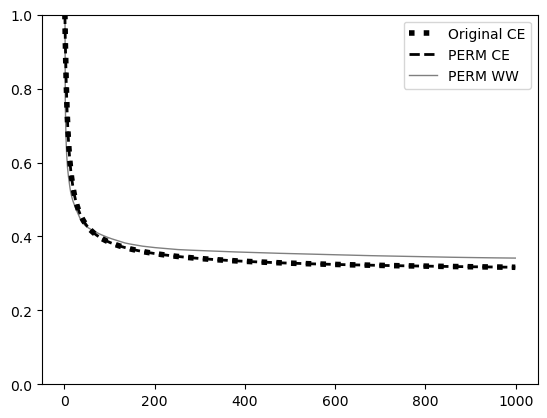

In [24]:
import matplotlib.pyplot as plt
plt.plot(hist_ORIG_CE.history['loss'], "k:",lw=4)
plt.plot(hist_PERM_CE.history['loss'], "k--",lw=2)
plt.plot(hist_PERM_WW.history['loss'], "k",lw=1,alpha=0.5)
plt.legend(["Original CE", "PERM CE", "PERM WW"])
plt.ylim((0,1))
plt.show()

From this graph, we see that the loss of the model trained with the original CE and with the PERM CE are identical. 

As a negative control and sanity check, note that the loss is different for PERM WW.